In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from TINTOlib.refined import REFINED
from kan import *
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


import traceback
import time
import gc
import copy
import traceback
import cv2
import math
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import csv

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# BEST  ACC = 0.733152

In [4]:
folder="data/FOREX_cadjpy-day-High"
x_col=["Bid_Open", "Bid_High", "Bid_Low", "Bid_Close", "Bid_Volume", "Ask_Open", "Ask_High", "Ask_Low", "Ask_Close","Ask_Volume"]
target_col=["class"]

# Functions

### Load Dataset and Images

In [5]:
def load_and_clean(npy_filename, y_filename, x_col, target_col):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    drop rows in the feature array that contain any NaNs, and apply
    the same mask to the label array.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename))
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Create a boolean mask for rows that do NOT have any NaN values in X
    valid_rows = ~np.isnan(X).any(axis=1)

    # Filter both arrays using the valid_rows mask
    X_clean = X[valid_rows]
    y_clean = y[valid_rows]
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X_clean)
    df_y = pd.DataFrame(y_clean)
    df_X.columns = x_col
    df_y.columns = target_col
    return df_X, df_y

In [6]:
def load_and_preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val, image_model, problem_type, batch_size=32):
    # Add target column to input for IGTD
    X_train_full = X_train.copy()
    X_train_full["target"] = y_train.values

    X_val_full = X_val.copy()
    X_val_full["target"] = y_val.values

    X_test_full = X_test.copy()
    X_test_full["target"] = y_test.values

    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        #print(X_train_full)
        image_model.fit_transform(X_train_full, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}/model.pkl')
    else:
        print("The images are already generated")

    # Load image paths
    imgs_train = pd.read_csv(os.path.join(f'{images_folder}/train', f'{problem_type}.csv'))
    imgs_train["images"] = images_folder + "/train/" + imgs_train["images"]

    if not os.path.exists(f'{images_folder}/val'):
        image_model.transform(X_val_full, f'{images_folder}/val')
    else:
        print("The images are already generated")

    imgs_val = pd.read_csv(os.path.join(f'{images_folder}/val', f'{problem_type}.csv'))
    imgs_val["images"] = images_folder + "/val/" + imgs_val["images"]

    if not os.path.exists(f'{images_folder}/test'):
        image_model.transform(X_test_full, f'{images_folder}/test')
    else:
        print("The images are already generated")

    imgs_test = pd.read_csv(os.path.join(f'{images_folder}/test', f'{problem_type}.csv'))
    imgs_test["images"] = images_folder + "/test/" + imgs_test["images"]

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in imgs_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in imgs_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in imgs_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)

    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape

In [7]:
def complete_coordinate_and_xcol(coordinate, x_col):
    """
    Given a coordinate (tuple of row, col arrays) and x_col feature list,
    return completed coordinate and x_col including empty positions.

    Empty positions are filled with labels: 'Ex1', 'Ex2', ...
    """

    row_coords, col_coords = coordinate
    max_row = row_coords.max()
    max_col = col_coords.max()
    max_c = max(max_row, max_col)
    # All possible coordinate slots
    full_coords = set((r, c) for r in range(max_col + 1) for c in range(max_col + 1))
    current_coords = set(zip(row_coords, col_coords))
    missing_coords = sorted(full_coords - current_coords)

    # Create updated coordinate arrays
    new_row_coords = list(row_coords)
    new_col_coords = list(col_coords)
    new_x_col = list(x_col)

    for idx, (r, c) in enumerate(missing_coords):
        new_row_coords.append(r)
        new_col_coords.append(c)
        new_x_col.append(f"Ex{idx+1}")

    completed_coordinate = (np.array(new_row_coords), np.array(new_col_coords))
    return completed_coordinate, new_x_col

In [8]:
def plot_feature_mapping(x_col, coordinate, scale=(4,4)):
    grid = np.full(scale, "", dtype=object)
    rows, cols = coordinate
    for i, (r, c) in enumerate(zip(rows, cols)):
        if i < len(x_col):
            grid[r, c] = x_col[i]
        else:
            grid[r, c] = "?"
    
    plt.figure(figsize=(scale[1] * 2, scale[0] * 2))
    for i in range(scale[0]):
        for j in range(scale[1]):
            plt.text(j, i, grid[i, j], ha='center', va='center', fontsize=10,
                     bbox=dict(facecolor='white', edgecolor='gray'))
    
    plt.xticks(np.arange(scale[1]))
    plt.yticks(np.arange(scale[0]))
    plt.grid(True)
    plt.title("Feature → Pixel Mapping")
    plt.gca().invert_yaxis()  # So row 0 is at the top
    plt.show()

In [9]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

### Functions for KAN

In [10]:
dtype = torch.get_default_dtype()
min_expected = 0.
max_expected = 1.

In [11]:
def plot_sorted_feature_importance(columns, importances):
    # Move to CPU and numpy if it's a GPU tensor
    if isinstance(importances, torch.Tensor):
        importances = importances.detach().cpu().numpy()

    # Pair columns and importances and sort by importance descending
    sorted_pairs = sorted(zip(columns, importances), key=lambda x: x[1], reverse=True)
    print(sorted_pairs)
    sorted_columns, sorted_importances = zip(*sorted_pairs)
    
    # Create the bar plot
    plt.figure(figsize=(4, 3))
    plt.barh(sorted_columns, sorted_importances, color='royalblue')
    plt.xlabel('Importance')
    plt.title('KAN Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    return sorted_pairs

In [12]:
def plot_training_ACC(y_true, y_pred, train_loss, val_loss, plot=False):
    clipped = torch.clamp(torch.round(y_pred), min=min_expected, max=max_expected)
    avg_rmse = torch.mean((clipped == y_true).type(dtype))
    print(avg_rmse)
    if plot:
        plt.figure(figsize=(5, 4))
        plt.plot(train_loss)
        plt.plot(val_loss)
        plt.legend(['train', 'val'])
        plt.ylabel('Accuracy')
        plt.xlabel('step')
        plt.yscale('log')
    return avg_rmse

In [13]:
def plot_confusion_matrix(y_true_tensor, y_pred_tensor, title="Confusion Matrix", plot=False):
    # Move tensors to CPU and detach if necessary
    clipped = torch.clamp(torch.round(y_pred_tensor), min=min_expected, max=max_expected)

    y_true = y_true_tensor.detach().cpu().numpy().flatten()
    y_pred = clipped.detach().cpu().numpy().flatten()

    # Round predictions if they are float (e.g., from sigmoid or regression)
    if y_pred.dtype.kind in {'f'}:
        y_pred = y_pred.round()

    # Get sorted list of all unique labels
    all_labels = sorted(set(y_true) | set(y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    print(cm)
    if plot:
        # Plot
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                    xticklabels=all_labels, yticklabels=all_labels)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(title)
        plt.tight_layout()
        plt.show()
    return cm

In [14]:
def train_acc_kan():
    rounded = torch.round(torch.round(model(dataset['train_input'])[:,0]))
    clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
    return torch.mean((clipped == dataset['train_label'][:,0]).type(dtype))

def val_acc_kan():
    rounded = torch.round(torch.round(model(dataset['val_input'])[:,0]))
    clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
    return torch.mean((clipped == dataset['val_label'][:,0]).type(dtype))

In [15]:
def custom_fit(model, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, 
               grid_update_num=10, loss_fn=None, lr=1., start_grid_update_step=-1, stop_grid_update_step=50, batch=-1,
               metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', 
               singularity_avoiding=False, y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None):
    '''
    training

    Args:
    -----
        dataset : dic
            contains dataset['train_input'], dataset['train_label'], dataset['val_input'], dataset['val_label']
        opt : str
            "LBFGS" or "Adam"
        steps : int
            training steps
        log : int
            logging frequency
        lamb : float
            overall penalty strength
        lamb_l1 : float
            l1 penalty strength
        lamb_entropy : float
            entropy penalty strength
        lamb_coef : float
            coefficient magnitude penalty strength
        lamb_coefdiff : float
            difference of nearby coefficits (smoothness) penalty strength
        update_grid : bool
            If True, update grid regularly before stop_grid_update_step
        grid_update_num : int
            the number of grid updates before stop_grid_update_step
        start_grid_update_step : int
            no grid updates before this training step
        stop_grid_update_step : int
            no grid updates after this training step
        loss_fn : function
            loss function
        lr : float
            learning rate
        batch : int
            batch size, if -1 then full.
        save_fig_freq : int
            save figure every (save_fig_freq) steps
        singularity_avoiding : bool
            indicate whether to avoid singularity for the symbolic part
        y_th : float
            singularity threshold (anything above the threshold is considered singular and is softened in some ways)
        reg_metric : str
            regularization metric. Choose from {'edge_forward_spline_n', 'edge_forward_spline_u', 'edge_forward_sum', 'edge_backward', 'node_backward'}
        metrics : a list of metrics (as functions)
            the metrics to be computed in training
        display_metrics : a list of functions
            the metric to be displayed in tqdm progress bar

    Returns:
    --------
        results : dic
            results['train_loss'], 1D array of training losses (RMSE)
            results['val_loss'], 1D array of val losses (RMSE)
            results['reg'], 1D array of regularization
            other metrics specified in metrics
        best_model:
    '''

    if lamb > 0. and not model.save_act:
        print('setting lamb=0. If you want to set lamb > 0, set model.save_act=True')
        
    old_save_act, old_symbolic_enabled = model.disable_symbolic_in_fit(lamb)

    pbar = tqdm(range(steps), desc='description', ncols=100)

    if loss_fn == None:
        loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
    else:
        loss_fn = loss_fn_eval = loss_fn

    grid_update_freq = int(stop_grid_update_step / grid_update_num)

    if opt == "Adam":
        optimizer = torch.optim.Adam(model.get_params(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.get_params(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32,
                          tolerance_change=1e-32,
                          tolerance_ys=1e-32)

    results = {}
    results['train_loss'] = []
    results['val_loss'] = []
    results['reg'] = []
    if metrics != None:
        for i in range(len(metrics)):
            results[metrics[i].__name__] = []

    if batch == -1 or batch > dataset['train_input'].shape[0]:
        batch_size = dataset['train_input'].shape[0]
        batch_size_val = dataset['val_input'].shape[0]
    else:
        batch_size = batch
        batch_size_val = batch

    global train_loss, reg_

    def closure():
        global train_loss, reg_
        optimizer.zero_grad()
        pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
        train_loss = loss_fn(pred, dataset['train_label'][train_id])
        if model.save_act:
            if reg_metric == 'edge_backward':
                model.attribute()
            if reg_metric == 'node_backward':
                model.node_attribute()
            reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
        else:
            reg_ = torch.tensor(0.)
        objective = train_loss + lamb * reg_
        objective.backward()
        return objective

    if save_fig:
        if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    
    best_model_state = None
    best_epoch = -1
    best_metric = 0
    val_metric = 0
    for epoch in pbar:
        
        if epoch == steps-1 and old_save_act:
            model.save_act = True
            
        if save_fig and epoch % save_fig_freq == 0:
            save_act = model.save_act
            model.save_act = True
        
        train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
        val_id = np.random.choice(dataset['val_input'].shape[0], batch_size_val, replace=False)

        if epoch % grid_update_freq == 0 and epoch < stop_grid_update_step and update_grid and epoch >= start_grid_update_step:
            model.update_grid(dataset['train_input'][train_id])

        if opt == "LBFGS":
            optimizer.step(closure)

        if opt == "Adam":
            pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
            train_loss = loss_fn(pred, dataset['train_label'][train_id])
            if model.save_act:
                if reg_metric == 'edge_backward':
                    model.attribute()
                if reg_metric == 'node_backward':
                    model.node_attribute()
                reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_ = torch.tensor(0.)
            loss = train_loss + lamb * reg_
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = loss_fn_eval(model.forward(dataset['val_input'][val_id]), dataset['val_label'][val_id])
        
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__].append(metrics[i]().item())
        
        results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
        results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())
        results['reg'].append(reg_.cpu().detach().numpy())

        if epoch % log == 0:
            if display_metrics == None:
                pbar.set_description("| train_loss: %.2e | val_loss: %.2e | reg: %.2e | " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(val_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))
                val_metric = val_loss
            else:
                string = ''
                data = ()
                for metric in display_metrics:
                    val_metric = results[metric][-1]
                    string += f' {metric}: %.2e |'
                    try:
                        results[metric]
                    except:
                        raise Exception(f'{metric} not recognized')
                    data += (results[metric][-1],)
                pbar.set_description(string % data)

        if val_metric > best_metric:
            best_epoch = epoch
            best_metric = val_metric
            best_model_state = copy.deepcopy(model.state_dict())

        if save_fig and epoch % save_fig_freq == 0:
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
            plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
            plt.close()
            model.save_act = save_act

    model.log_history('fit')
    # revert back to original state
    model.symbolic_enabled = old_symbolic_enabled
    print(f"✅ Best validation Accuracy: {best_metric:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

### Grad CAM Functions

In [16]:
def grad_cam_side_by_side(model, model_state, num_input, img_input, x_col, coordinate,
                          zoom=1, target_index=None, save_path=None, show=True):
    model.load_state_dict(model_state)
    model.eval()
    model.zero_grad()

    if num_input.dim() == 1:
        num_input = num_input.unsqueeze(0)
    if img_input.dim() == 3:
        img_input = img_input.unsqueeze(0)

    num_input = num_input.to(model.device)
    img_input = img_input.to(model.device)

    # Store activations and gradients
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations["value"] = output.detach()

    def backward_hook(module, grad_input, grad_output):
        gradients["value"] = grad_output[0].detach()

    conv_layer = model.cnn_branch[0]
    h_fwd = conv_layer.register_forward_hook(forward_hook)
    h_bwd = conv_layer.register_full_backward_hook(backward_hook)

    output = model(num_input, img_input)
    target = output if target_index is None else output[:, target_index]
    target.backward()

    act = activations["value"].squeeze(0)
    grad = gradients["value"].squeeze(0)
    weights = grad.mean(dim=(1, 2))
    cam = torch.zeros_like(act[0])
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = torch.relu(cam)
    if cam.max() > 0:
        cam -= cam.min()
        cam /= cam.max()
    else:
        cam[:] = 0.0


    cam_resized = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=img_input.shape[-2:], mode='bilinear', align_corners=False)
    #print(cam_resized)
    heatmap = cam_resized.squeeze().cpu()

    img_disp = img_input.squeeze().detach().cpu()
    if img_disp.shape[0] == 1:
        img_disp = img_disp[0]
        cmap = 'gray'
    else:
        img_disp = img_disp.permute(1, 2, 0)
        cmap = None

    h, w = img_disp.shape[:2]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(img_disp, cmap=cmap)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    im = axs[1].imshow(img_disp, cmap=cmap)
    heatmap_img = axs[1].imshow(heatmap, cmap='jet', alpha=0.5)
    axs[1].set_title("Grad-CAM")
    axs[1].axis('off')

    # Add colorbar (legend)
    cbar = fig.colorbar(heatmap_img, ax=axs[1], fraction=0.046, pad=0.04)
    cbar.set_label("Grad-CAM Intensity", fontsize=10)

    # Overlay abbreviated features
    for i, col in enumerate(x_col):
        abbrev = col.split("-")[0][:8]
        if i < len(coordinate[0]):
            r, c = coordinate[0][i], coordinate[1][i]
            ry = r * zoom + zoom // 2
            cx = c * zoom + zoom // 2
            if ry < h and cx < w:
                axs[1].text(cx, ry, abbrev,
                            color='white', fontsize=9, ha='center', va='center',
                            bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))
                axs[0].text(cx, ry, abbrev,
                            color='white', fontsize=9, ha='center', va='center',
                            bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    if show:
        plt.show()
    else:
        plt.close()

    h_fwd.remove()
    h_bwd.remove()

    return heatmap

In [17]:
def heatmap_to_feature_relevance(heatmap, coordinate, x_col, zoom=1):
    """
    Map heatmap pixel intensities to their corresponding features using coordinate and zoom.
    Returns a dictionary of {feature_name: relevance_score}.
    """
    feature_scores = {}

    for i, col in enumerate(x_col):
        if i < len(coordinate[0]):
            r, c = coordinate[0][i], coordinate[1][i]
            ry = r * zoom + zoom // 2
            cx = c * zoom + zoom // 2
            if ry < heatmap.shape[0] and cx < heatmap.shape[1]:
                feature_scores[col] = heatmap[ry, cx].item()

    return feature_scores

def plot_feature_relevance_bar(feature_scores):
    """
    Plots a horizontal bar chart of feature relevance from Grad-CAM heatmap.
    """
    sorted_scores = sorted(feature_scores.items(), key=lambda item: item[1], reverse=True)
    print(sorted_scores)
    features, scores = zip(*sorted_scores)

    plt.figure(figsize=(6, 3))
    plt.barh(features, scores, color='royalblue')
    plt.xlabel("Grad-CAM Relevance")
    plt.title("Feature Relevance for Test")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    return sorted_scores

In [18]:
def compute_avg_feature_relevance_from_val(model, model_state, val_inputs, val_imgs, coordinate, x_col, zoom=1):
    """
    Computes average Grad-CAM feature relevance over all validation instances with a tqdm progress bar.

    Args:
        model: Trained model
        model_state: Trained weights to be loaded
        val_inputs: List or tensor of numerical inputs
        val_imgs: List or tensor of image inputs
        coordinate: IGTD-style coordinate tuple (row array, col array)
        x_col: List of feature names (including extras)
        zoom: Zoom level used when generating the images

    Returns:
        Dictionary of average feature relevance
    """
    accumulated_scores = {feature: [] for feature in x_col}

    for num_input, img_input in tqdm(zip(val_inputs, val_imgs), total=len(val_inputs), desc="Computing Grad-CAM"):
        heatmap = grad_cam_side_by_side(
            model=model,
            model_state=model_state,
            num_input=num_input,
            img_input=img_input,
            coordinate=coordinate,
            x_col=x_col,
            zoom=zoom,
            show=False
        )
        scores = heatmap_to_feature_relevance(heatmap, coordinate, x_col, zoom)
        for feature, value in scores.items():
            accumulated_scores[feature].append(value)

    # Compute average
    avg_scores = {feature: float(np.mean(values)) if values else 0.0
                  for feature, values in accumulated_scores.items()}

    return avg_scores


### CNN Functions

In [19]:
def fit_cnn_only_model(model, dataset, steps=100, lr=1.0, loss_fn=None, batch=-1, opt="LBFGS"):
    """
    Trains a CNN-only model using LBFGS.

    Args:
        model: CNN-only PyTorch model.
        dataset: Dictionary with keys: 'train_img', 'train_label', 'val_img', 'val_label'.
        steps: Number of training iterations.
        lr: Learning rate.
        loss_fn: Loss function. Defaults to MSE.

    Returns:
        results: Dict with lists of train/val losses.
        best_model_state: Best weights based on val loss.
    """
    device = model.device
    if loss_fn is None:
        loss_fn = nn.MSELoss()

    # Optimizer selection
    if opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    elif opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer '{opt}'")

    n_train = dataset["train_img"].shape[0]
    n_val = dataset["val_img"].shape[0]
    batch_size = n_train if batch == -1 or batch > n_train else batch

    results = {'train_loss': [], 'val_loss': []}
    best_model_state = None
    best_loss = float("inf")
    best_epoch = -1

    pbar = tqdm(range(steps), desc="Training CNN Only ({opt})", ncols=100)

    for step in pbar:
        train_idx = np.random.choice(n_train, batch_size, replace=False)
        #train_idx = torch.randperm(n_train)[:min(32, n_train)]  # small batch
        x_train = dataset["train_img"][train_idx].to(device)
        y_train = dataset["train_label"][train_idx].to(device)
        if opt == "LBFGS":
            def closure():
                optimizer.zero_grad()
                output = model(0, x_train)
                loss = loss_fn(output, y_train)
                loss.backward()
                return loss
            optimizer.step(closure)
            train_loss = closure().item()

        else:  # AdamW
            optimizer.zero_grad()
            output = model(0, x_train)
            loss = loss_fn(output, y_train)
            loss.backward()
            optimizer.step()
            train_loss = loss.item()

        with torch.no_grad():
            val_output = model(0, dataset["val_img"].to(device))
            val_loss = loss_fn(val_output, dataset["val_label"].to(device)).item()

        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = step
            best_model_state = copy.deepcopy(model.state_dict())

        pbar.set_description(f"| Train: {train_loss:.4e} | Val: {val_loss:.4e} |")

    print(f"✅ Best validation loss: {best_loss:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [20]:
def build_custom_cnn_model(cnn_blocks, dense_layers, imgs_shape, device='cuda'):
    class CustomCNNModel(nn.Module):
        def __init__(self):
            super(CustomCNNModel, self).__init__()
            self.device = device

            cnn_layers = []
            in_channels = imgs_shape[0]
            out_channels = 16
            cnn_blocks_list = [10, 7, 5]
            size_layer_norm = cnn_blocks_list[cnn_blocks-1]
            
            f_layer_size = 10 - cnn_blocks*2
            for i in range(cnn_blocks):
                cnn_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2))
                
                if i < cnn_blocks - 1:
                    cnn_layers.append(nn.BatchNorm2d(out_channels))
                    cnn_layers.append(nn.ReLU())
                    cnn_layers.append(nn.MaxPool2d(2))
                else:
                    # Last block: LayerNorm + Sigmoid + Flatten
                    cnn_layers.append(nn.LayerNorm([out_channels, size_layer_norm, size_layer_norm]))
                    cnn_layers.append(nn.Sigmoid())
                    cnn_layers.append(nn.Flatten())
                in_channels = out_channels
                out_channels *= 2

            self.cnn_branch = nn.Sequential(*cnn_layers).to(device)
            self.flat_size = self._get_flat_size(imgs_shape)

            # Dense (FC) layers
            fc_layers = []
            input_dim = self.flat_size
            for i in range(dense_layers - 1):
                fc_layers.append(nn.Linear(int(input_dim), int(input_dim // 2)))
                fc_layers.append(nn.ReLU())
                input_dim = input_dim // 2
            fc_layers.append(nn.Linear(int(input_dim), 1))

            self.fc = nn.Sequential(*fc_layers).to(device)

        def _get_flat_size(self, imgs_shape):
            dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
            x = self.cnn_branch(dummy_input)
            return x.shape[1]

        def forward(self, num_input, img_input):
            img_input = img_input.to(self.device)
            features = self.cnn_branch(img_input)
            output = self.fc(features)
            return output

    return CustomCNNModel()

### Write metrics

In [21]:
def create_csv_with_header(filename, columns_opt):
    header=['kan_neurons', 'kan_grid', 'lamb', columns_opt, 'ACC','Conf_Mtx','Best_Epoch','KAN_Relevance','CNN_Relevance','KAN M.R.F.','CNN M.R.F.']
    """Creates a CSV file with a given header."""
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)

In [22]:
def format_top_3(pairs):
    return '\n'.join(f"{k}: {v:.2f}" for k, v in pairs[:3])

In [23]:
def append_row_to_csv(filename, kan_neurons, kan_grid, lamb, opt_col_val, acc, cm, best_epoch, k_rel, cnn_rel, kan_mrf, cnn_mrf):
    row = [kan_neurons, kan_grid, lamb, opt_col_val, acc, cm, best_epoch, k_rel, cnn_rel, format_top_3(kan_mrf), format_top_3(cnn_mrf)]
    ['Configuration', opt_col_val,'ACC','Conf_Mtx','Best_Epoch','KAN_Relevance','CNN_Relevance','KAN M.R.F.','CNN M.R.F.']
    """Appends a single row to an existing CSV file."""
    if not os.path.isfile(filename):
        raise FileNotFoundError(f"{filename} does not exist. Please create the file first with a header.")
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(row)

### Hybrid Functions

In [24]:
def print_mkan_vs_cnn_relevance(feature_scores, mkan_len):
    if isinstance(feature_scores, torch.Tensor):
        feature_scores = feature_scores.detach().cpu().numpy()

    mkan_relevance = feature_scores[:mkan_len].sum()
    cnn_relevance = feature_scores[mkan_len:].sum()
    m_kan_relevance_perct = float(mkan_relevance/(mkan_relevance+cnn_relevance))
    cnn_relevance_perct = float(cnn_relevance/(mkan_relevance+cnn_relevance))
    print(f"M_KAN Relevance: {m_kan_relevance_perct}")
    print(f"CNN Relevance: {cnn_relevance_perct}")
    return m_kan_relevance_perct, cnn_relevance_perct

In [25]:
def plot_mkan_vs_cnn_relevance(feature_scores, mkan_len=6, title="Feature Relevance Split"):
    """
    Plots a pie chart comparing the total feature relevance from m_kan output vs CNN output.

    Args:
        feature_scores (torch.Tensor or list): 1D tensor of relevance values from final_kan.
        mkan_len (int): Number of dimensions from m_kan (default: 6).
        title (str): Title for the pie chart.
    """
    if isinstance(feature_scores, torch.Tensor):
        feature_scores = feature_scores.detach().cpu().numpy()

    mkan_relevance = feature_scores[:mkan_len].sum()
    cnn_relevance = feature_scores[mkan_len:].sum()

    sizes = [mkan_relevance, cnn_relevance]
    labels = ['m_kan Output', 'CNN Output']
    explode = (0.05, 0)  # Slightly explode m_kan slice for emphasis

    plt.figure(figsize=(3, 3))
    plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%',
            shadow=True, startangle=140, colors=["#66c2a5", "#fc8d62"])
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [26]:
def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="AdamW", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        f_old_save_act, f_old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_input"].shape[0]
    n_eval  = dataset["val_input"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif opt == "LBFGS":        
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {'train_loss': [], 'eval_loss': [], 'reg': []}
    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_metric = 0
    val_metric = 0

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)
        
        cached_loss = {}
        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val_inner += model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            cached_loss['loss'] = loss_val_inner.detach()
            cached_loss['reg'] = reg_val_inner.detach()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            model.m_kan.update_grid(mlp_batch)
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated = model.get_concat_output(mlp_batch, cnn_batch)

            model.final_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = cached_loss['loss']
            reg_val = cached_loss['reg']
        else:  # AdamW branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()


        with torch.no_grad():
            mlp_eval = dataset["val_input"][eval_indices]
            img_eval = dataset["val_img"][eval_indices]
            target_eval = dataset["val_label"][eval_indices]
            eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())


        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            string = ''
            data = ()
            for metric in display_metrics:
                val_metric = results[metric][-1]
                string += f' {metric}: %.2e |'
                try:
                    results[metric]
                except:
                    raise Exception(f'{metric} not recognized')
                data += (results[metric][-1],)
            pbar.set_description(string % data)

        if val_metric > best_metric:
            best_epoch = step
            best_metric = val_metric
            best_model_state = copy.deepcopy(model.state_dict())

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')
    print(f"✅ Best validation Accuracy: {best_metric:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [27]:
import traceback

def try_create_model(model_class, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim, alpha, hidden_dim, embed_dim, num_heads):
    try:
        model = model_class(attributes, imgs_shape, kan_neurons, kan_grid,
                            cnn_bottleneck_dim=cnn_bottleneck_dim, alpha=alpha, hidden_dim=hidden_dim, embed_dim=embed_dim, num_heads=num_heads)
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [28]:
def cnn_branch_relevance(model, best_model_state):
    avg_scores = compute_avg_feature_relevance_from_val(
        model=model,
        model_state=best_model_state,
        val_inputs=dataset["test_input"],
        val_imgs=dataset["test_img"],
        coordinate=completed_coordinate,
        x_col=completed_x_col,
        zoom=2
    )
    return plot_feature_relevance_bar(avg_scores)

In [29]:
def train_and_plot_relevance(model_class, kan_neurons, kan_grid, lamb, steps, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, n_kan_len=None, filename=None, opt_col_val=None):
    torch.cuda.empty_cache()
    gc.collect()
    model = try_create_model(model_class, attributes, imgs_shape, kan_neurons=kan_neurons, kan_grid=kan_grid,
                             cnn_bottleneck_dim=cnn_bottleneck_dim, alpha=alpha, hidden_dim=hidden_dim, embed_dim=embed_dim, num_heads=num_heads)
    def train_acc_hybrid():
        rounded = torch.round(torch.round(model(dataset['train_input'], dataset['train_img'])[:,0]))
        clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
        return torch.mean((clipped == dataset['train_label'][:,0]).type(dtype))
    
    def val_acc_hybrid():
        rounded = torch.round(torch.round(model(dataset['val_input'], dataset['val_img'])[:,0]))
        clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
        return torch.mean((clipped == dataset['val_label'][:,0]).type(dtype))

    model_state, results, best_epoch = fit_hybrid_dataloaders(
        model, dataset, opt="LBFGS", steps=steps, lamb=lamb,
        metrics=(train_acc_hybrid, val_acc_hybrid), display_metrics=['train_acc_hybrid', 'val_acc_hybrid'])

    model.load_state_dict(model_state)
    acc = plot_training_ACC(dataset['test_label'][:,0], model(dataset['test_input'], dataset['test_img'])[:,0],
                            results['train_acc_hybrid'], results['val_acc_hybrid'])

    cm = plot_confusion_matrix(dataset['test_label'][:,0], model(dataset['test_input'], dataset['test_img'])[:,0], title="Confusion Matrix")

    if not n_kan_len:
        n_kan_len = kan_neurons
    k_rel, cnn_rel = print_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=n_kan_len)
    #plot_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=kan_neurons)
    kan_mrf = ""#plot_sorted_feature_importance(x_col, model.m_kan.feature_score)
    cnn_mrf = ""#cnn_branch_relevance(model, model_state)

    append_row_to_csv(filename, kan_neurons, kan_grid, lamb, opt_col_val, acc.item(), cm, best_epoch, k_rel, cnn_rel, kan_mrf, cnn_mrf)

### Models Class

### Models Class Hybrids

In [33]:
class Model4_1(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model4_1, self).__init__()

        self.device = device

        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.LayerNorm([16, 10, 10]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        # Dummy pass to get flattened size
        self.flat_size = self._get_flat_size(imgs_shape)

        # Bottleneck layer
        self.cnn_bottleneck = nn.Linear(self.flat_size, cnn_bottleneck_dim).to(device)

        # KAN branch
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Final KAN layer
        self.final_kan = KAN(
            width=[cnn_bottleneck_dim + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

    def _get_flat_size(self, imgs_shape):
        dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
        x = self.cnn_branch(dummy_input)
        return x.shape[1]

    def get_concat_output(self, mlp_input, cnn_input):
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)

        conv_out = self.cnn_branch(cnn_input)
        cnn_output = self.cnn_bottleneck(conv_out)

        kan_output = self.m_kan(kan_input)

        return torch.cat((kan_output, cnn_output), dim=1)

    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [34]:
class Model4_2(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model4_2, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.LayerNorm([16, 10, 10]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device
        self.alpha = alpha


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        cnn_output = cnn_output * self.alpha
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [35]:
class Model4_3(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model4_3, self).__init__()
        self.device = device

        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.LayerNorm([16, 10, 10]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        self.flat_size = self._get_flat_size(imgs_shape)

        # KAN branch
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Gating MLP: inputs are concatenated CNN + KAN representations
        self.gate_net = nn.Sequential(
            nn.Linear(self.flat_size + kan_neurons, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output ∈ [0,1]
        ).to(device)

        # Final regressor (KAN layer)
        self.final_kan = KAN(
            width=[kan_neurons + self.flat_size, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

    def _get_flat_size(self, imgs_shape):
        dummy_input = torch.zeros(4, *imgs_shape, device=self.device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        mlp_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)

        kan_out = self.m_kan(mlp_input)                  # shape: (B, kan_neurons)
        cnn_out = self.cnn_branch(cnn_input)             # shape: (B, cnn_flat)

        concat = torch.cat((kan_out, cnn_out), dim=1)    # For gating
        alpha = self.gate_net(concat)                    # shape: (B, 1)

        gated_kan = (1 - alpha) * kan_out                # shape: (B, kan_neurons)
        gated_cnn = alpha * cnn_out                      # shape: (B, cnn_flat)

        return torch.cat((gated_kan, gated_cnn), dim=1)  # shape: (B, total)

    def forward(self, mlp_input, cnn_input):
        fused = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(fused)


In [30]:
class Model4_4(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model4_4, self).__init__()
        self.device = device

        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.LayerNorm([16, 10, 10]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        self.flat_size = self._get_flat_size(imgs_shape)

        # KAN Branch
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Linear projections for Q, K, V
        self.query_proj = nn.Linear(kan_neurons, embed_dim).to(device)
        self.key_proj = nn.Linear(self.flat_size, embed_dim).to(device)
        self.value_proj = nn.Linear(self.flat_size, embed_dim).to(device)

        # Attention module
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True).to(device)

        # Final regression layer (KAN again)
        self.final_kan = KAN(
            width=[embed_dim, 1], grid=kan_grid, k=3, seed=SEED, device=device
        )
    
    def get_concat_output(self, mlp_input, cnn_input):
        # Get KAN and CNN outputs
        kan_out = self.m_kan(mlp_input.to(self.device))  # [B, D_kan]
        cnn_out = self.cnn_branch(cnn_input.to(self.device))  # [B, D_cnn]

        # Project into Q, K, V space
        Q = self.query_proj(kan_out).unsqueeze(1)  # [B, 1, E]
        K = self.key_proj(cnn_out).unsqueeze(1)    # [B, 1, E]
        V = self.value_proj(cnn_out).unsqueeze(1)  # [B, 1, E]
        # Cross-attention: KAN attends to CNN
        attn_out, _ = self.attn(Q, K, V)  # [B, 1, E]
        attn_out = attn_out.squeeze(1)   # [B, E]

        return attn_out



    def _get_flat_size(self, imgs_shape):
        dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
        return self.cnn_branch(dummy_input).shape[1]

    def forward(self, mlp_input, cnn_input):
        attn_out = self.get_concat_output(mlp_input, cnn_input)

        return self.final_kan(attn_out)

# Load Dataset and Images

In [31]:
X_train, y_train = load_and_clean('N_train.npy', 'y_train.npy',x_col, target_col)
X_test, y_test   = load_and_clean('N_test.npy',  'y_test.npy', x_col, target_col)
X_val, y_val     = load_and_clean('N_val.npy',   'y_val.npy', x_col, target_col)

In [32]:
# Get the shape of the dataframe
num_columns = X_train.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
image_size = math.ceil(math.sqrt(num_columns))
print(image_size)

4


In [33]:
dataset_name = 'FOREX_cadjpy-day-High'
#Select the model and the parameters
problem_type = "supervised"
image_model = REFINED(problem=problem_type, zoom=2, random_seed=SEED)
name = f"Refined"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Classification/{dataset_name}/images_{dataset_name}_{name}"

In [34]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, y_train, X_test, y_test, X_val, y_val,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=16
)

The images are already generated
The images are already generated
The images are already generated
Images shape:  (3, 8, 8)
Attributes:  10


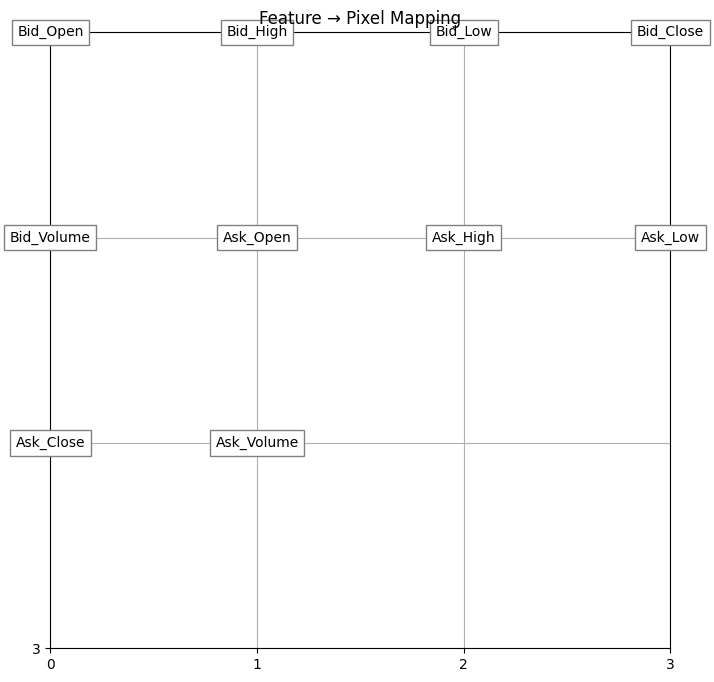

In [35]:
if hasattr(image_model, 'coordinate'):
    coordinates = image_model.coordinate
else:
    coordinates = (np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2]),
                   np.array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1]))

plot_feature_mapping(x_col, coordinates, scale=[4, 4])

In [36]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_input": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_label": train_target.to(device),
    "val_input": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_label": val_target.to(device),
    "test_input": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_label": test_target.to(device),
}

In [37]:
# Print the shapes of the tensors
print("Train data shape:", dataset['train_input'].shape)
print("Train target shape:", dataset['train_label'].shape)
print("Test data shape:", dataset['test_input'].shape)
print("Test target shape:", dataset['test_label'].shape)
print("Validation data shape:", dataset['val_input'].shape)
print("Validation target shape:", dataset['val_label'].shape)

Train data shape: torch.Size([1173, 10])
Train target shape: torch.Size([1173, 1])
Test data shape: torch.Size([367, 10])
Test target shape: torch.Size([367, 1])
Validation data shape: torch.Size([294, 10])
Validation target shape: torch.Size([294, 1])


In [38]:
completed_coordinate, completed_x_col = complete_coordinate_and_xcol(coordinates, x_col)

# Set Files Name

In [39]:
filename_1=f'{dataset_name}_Refined_Concat_Op1.csv'
filename_2=f'{dataset_name}_Refined_Concat_Op2.csv'
filename_3=f'{dataset_name}_Refined_Concat_Op3.csv'
filename_4=f'{dataset_name}_Refined_Concat_Op4.csv'

In [40]:
columns_opt1 = 'cnn_bottleneck_dim'
columns_opt2 = 'alpha'
columns_opt3 = 'hidden_dim'
columns_opt4 = 'embed_dim, num_heads'

# Option 1: Concat KAN with (CNN with dense layer to reduce output_size)

In [49]:
create_csv_with_header(filename_1, columns_opt1)

In [54]:
print("------------------------------ kan_neurons=3, kan_grid=3, lamb=1e-05 ------------------------------")
for cnn_bottleneck_dim in [1, 2, 4, 6, 8, 10, 12]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model4_1, kan_neurons=3, kan_grid=3, lamb=1e-05, steps=30, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)

print("------------------------------ kan_neurons=2, kan_grid=4, lamb=1e-07 ------------------------------")
for cnn_bottleneck_dim in [1, 2, 3, 6, 9, 12]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model4_1, kan_neurons=2, kan_grid=4, lamb=1e-07, steps=30, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)

print("------------------------------ kan_neurons=3, kan_grid=7, lamb=1e-06 ------------------------------")
for cnn_bottleneck_dim in [1, 2, 3, 6, 7, 9, 10, 12]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model4_1, kan_neurons=3, kan_grid=7, lamb=1e-06, steps=30, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)


print("------------------------------ kan_neurons=5, kan_grid=7, lamb=0.0001 ------------------------------")
for cnn_bottleneck_dim in [1, 2, 4, 6, 8]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model4_1, kan_neurons=5, kan_grid=7, lamb=0.0001, steps=30, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)

------------------------------ kan_neurons=3, kan_grid=3, lamb=1e-05 ------------------------------
cnn_bottleneck_dim: 1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.58e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.96it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 2 epoch
tensor(0.7112, device='cuda:0')
[[123  60]
 [ 46 138]]
M_KAN Relevance: 0.9997166991233826
CNN Relevance: 0.0002833500038832426
cnn_bottleneck_dim: 2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.53e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 30/30 [00:08<00:00,  3.34it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 8 epoch
tensor(0.7248, device='cuda:0')
[[131  52]
 [ 49 135]]
M_KAN Relevance: 0.3467988669872284
CNN Relevance: 0.653201162815094
cnn_bottleneck_dim: 4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.58e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.17it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 3 epoch
tensor(0.7193, device='cuda:0')
[[125  58]
 [ 45 139]]
M_KAN Relevance: 0.7381497025489807
CNN Relevance: 0.2618502974510193
cnn_bottleneck_dim: 6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.49e-01 | val_acc_hybrid: 7.18e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.27it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 2 epoch
tensor(0.7221, device='cuda:0')
[[127  56]
 [ 46 138]]
M_KAN Relevance: 0.13249698281288147
CNN Relevance: 0.8675029873847961
cnn_bottleneck_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.54e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 30/30 [00:08<00:00,  3.37it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 6 epoch
tensor(0.7193, device='cuda:0')
[[127  56]
 [ 47 137]]
M_KAN Relevance: 0.07901030778884888
CNN Relevance: 0.9209896922111511
cnn_bottleneck_dim: 10
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.43e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.25it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 10 epoch
tensor(0.7384, device='cuda:0')
[[131  52]
 [ 44 140]]
M_KAN Relevance: 0.15751607716083527
CNN Relevance: 0.8424838781356812
cnn_bottleneck_dim: 12
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.48e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.31it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 5 epoch
tensor(0.7221, device='cuda:0')
[[123  60]
 [ 42 142]]
M_KAN Relevance: 0.25490161776542664
CNN Relevance: 0.745098352432251
------------------------------ kan_neurons=2, kan_grid=4, lamb=1e-07 ------------------------------
cnn_bottleneck_dim: 1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.62e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 30/30 [00:08<00:00,  3.39it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 3 epoch
tensor(0.7357, device='cuda:0')
[[141  42]
 [ 55 129]]
M_KAN Relevance: 0.9999998807907104
CNN Relevance: 1.0472367506508817e-07
cnn_bottleneck_dim: 2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.50e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.09it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 2 epoch
tensor(0.7166, device='cuda:0')
[[126  57]
 [ 47 137]]
M_KAN Relevance: 0.1816624402999878
CNN Relevance: 0.8183375597000122
cnn_bottleneck_dim: 3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.31it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 2 epoch
tensor(0.7139, device='cuda:0')
[[135  48]
 [ 57 127]]
M_KAN Relevance: 0.7033688426017761
CNN Relevance: 0.29663121700286865
cnn_bottleneck_dim: 6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.54e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.21it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 10 epoch
tensor(0.7248, device='cuda:0')
[[134  49]
 [ 52 132]]
M_KAN Relevance: 0.10679197311401367
CNN Relevance: 0.8932080268859863
cnn_bottleneck_dim: 9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.63e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 30/30 [00:08<00:00,  3.33it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 3 epoch
tensor(0.7193, device='cuda:0')
[[121  62]
 [ 41 143]]
M_KAN Relevance: 0.24957223236560822
CNN Relevance: 0.750427782535553
cnn_bottleneck_dim: 12
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.59e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 30/30 [00:08<00:00,  3.37it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.4150e-01 at 3 epoch
tensor(0.6894, device='cuda:0')
[[118  65]
 [ 49 135]]
M_KAN Relevance: 0.19384698569774628
CNN Relevance: 0.8061529994010925
------------------------------ kan_neurons=3, kan_grid=7, lamb=1e-06 ------------------------------
cnn_bottleneck_dim: 1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.74e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 30/30 [00:08<00:00,  3.38it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9388e-01 at 25 epoch
tensor(0.6975, device='cuda:0')
[[129  54]
 [ 57 127]]
M_KAN Relevance: 0.9377152919769287
CNN Relevance: 0.0622846744954586
cnn_bottleneck_dim: 2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.32it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 8 epoch
tensor(0.7166, device='cuda:0')
[[133  50]
 [ 54 130]]
M_KAN Relevance: 0.2533082664012909
CNN Relevance: 0.7466917037963867
cnn_bottleneck_dim: 3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.69e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 30/30 [00:08<00:00,  3.35it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 3 epoch
tensor(0.6866, device='cuda:0')
[[123  60]
 [ 55 129]]
M_KAN Relevance: 0.3805297613143921
CNN Relevance: 0.6194702386856079
cnn_bottleneck_dim: 6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.50e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 30/30 [00:08<00:00,  3.35it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 5 epoch
tensor(0.7193, device='cuda:0')
[[128  55]
 [ 48 136]]
M_KAN Relevance: 0.2887974679470062
CNN Relevance: 0.7112025022506714
cnn_bottleneck_dim: 7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.69e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 30/30 [00:08<00:00,  3.54it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 13 epoch
tensor(0.7003, device='cuda:0')
[[129  54]
 [ 56 128]]
M_KAN Relevance: 0.37242090702056885
CNN Relevance: 0.6275790929794312
cnn_bottleneck_dim: 9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.75e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 30/30 [00:08<00:00,  3.44it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 5 epoch
tensor(0.7057, device='cuda:0')
[[130  53]
 [ 55 129]]
M_KAN Relevance: 0.22232754528522491
CNN Relevance: 0.7776724696159363
cnn_bottleneck_dim: 10
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.65e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.13it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 5 epoch
tensor(0.7193, device='cuda:0')
[[127  56]
 [ 47 137]]
M_KAN Relevance: 0.18978837132453918
CNN Relevance: 0.8102115988731384
cnn_bottleneck_dim: 12
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.63e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:08<00:00,  3.42it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 5 epoch
tensor(0.7030, device='cuda:0')
[[123  60]
 [ 49 135]]
M_KAN Relevance: 0.21848483383655548
CNN Relevance: 0.7815151214599609
------------------------------ kan_neurons=5, kan_grid=7, lamb=0.0001 ------------------------------
cnn_bottleneck_dim: 1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.81e-01 | val_acc_hybrid: 6.53e-01 |: 100%|█████| 30/30 [00:08<00:00,  3.46it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8707e-01 at 4 epoch
tensor(0.6894, device='cuda:0')
[[133  50]
 [ 64 120]]
M_KAN Relevance: 0.9855363368988037
CNN Relevance: 0.014463663101196289
cnn_bottleneck_dim: 2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.78e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.75it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 3 epoch
tensor(0.6921, device='cuda:0')
[[129  54]
 [ 59 125]]
M_KAN Relevance: 0.43948879837989807
CNN Relevance: 0.5605112314224243
cnn_bottleneck_dim: 4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.89e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 30/30 [00:11<00:00,  2.53it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 21 epoch
tensor(0.6975, device='cuda:0')
[[130  53]
 [ 58 126]]
M_KAN Relevance: 0.5776238441467285
CNN Relevance: 0.42237621545791626
cnn_bottleneck_dim: 6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.89e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.13it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 3 epoch
tensor(0.7003, device='cuda:0')
[[122  61]
 [ 49 135]]
M_KAN Relevance: 0.38557228446006775
CNN Relevance: 0.6144276857376099
cnn_bottleneck_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_1


 train_acc_hybrid: 7.75e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.02it/s]

saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 7 epoch
tensor(0.7166, device='cuda:0')
[[139  44]
 [ 60 124]]
M_KAN Relevance: 0.40885379910469055
CNN Relevance: 0.5911462306976318


# Option 2: Multiply CNN output by factor

In [55]:
create_csv_with_header(filename_2, columns_opt2)

In [59]:
print("------------------------------ kan_neurons=3, kan_grid=3, lamb=1e-05 ------------------------------")
for alpha in [.9,.8,.75,.7,.6,.5,.4,.3,.25,.2,.1,.05,.01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model4_2, kan_neurons=3, kan_grid=3, lamb=1e-05, steps=30, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

print("------------------------------ kan_neurons=2, kan_grid=4, lamb=1e-07 ------------------------------")
for alpha in [.9,.8,.75,.7,.6,.5,.5,.4,.3,.25,.2,.1,.05,.01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model4_2, kan_neurons=2, kan_grid=4, lamb=1e-07, steps=30, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

print("------------------------------ kan_neurons=3, kan_grid=7, lamb=1e-06 ------------------------------")
for alpha in [.9,.8,.75,.7,.6,.5,.4,.3,.25,.2,.1,.05,.01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model4_2, kan_neurons=3, kan_grid=7, lamb=1e-06, steps=30, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

print("------------------------------ kan_neurons=5, kan_grid=7, lamb=0.0001 ------------------------------")
for alpha in [.9,.8,.75,.7,.6,.5,.4,.3,.25,.2,.1,.05,.01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model4_2, kan_neurons=5, kan_grid=7, lamb=0.0001, steps=30, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

------------------------------ kan_neurons=3, kan_grid=3, lamb=1e-05 ------------------------------
alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.58e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 30/30 [00:40<00:00,  1.36s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 3 epoch
tensor(0.7166, device='cuda:0')
[[121  62]
 [ 42 142]]
M_KAN Relevance: 0.011624307371675968
CNN Relevance: 0.988375723361969
alpha: 0.8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.52e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:40<00:00,  1.34s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 22 epoch
tensor(0.7221, device='cuda:0')
[[138  45]
 [ 57 127]]
M_KAN Relevance: 0.01480176392942667
CNN Relevance: 0.9851981997489929
alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.77e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 30/30 [00:39<00:00,  1.32s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 2 epoch
tensor(0.7248, device='cuda:0')
[[125  58]
 [ 43 141]]
M_KAN Relevance: 0.020281504839658737
CNN Relevance: 0.9797185063362122
alpha: 0.7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.66e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 30/30 [00:38<00:00,  1.28s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 8 epoch
tensor(0.7357, device='cuda:0')
[[131  52]
 [ 45 139]]
M_KAN Relevance: 0.01371759083122015
CNN Relevance: 0.9862823486328125
alpha: 0.6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.61e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 30/30 [00:38<00:00,  1.30s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 9 epoch
tensor(0.7275, device='cuda:0')
[[129  54]
 [ 46 138]]
M_KAN Relevance: 0.014672531746327877
CNN Relevance: 0.9853274822235107
alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:40<00:00,  1.35s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 23 epoch
tensor(0.7166, device='cuda:0')
[[137  46]
 [ 58 126]]
M_KAN Relevance: 0.011304229497909546
CNN Relevance: 0.9886958003044128
alpha: 0.4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.65e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 30/30 [00:40<00:00,  1.34s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 22 epoch
tensor(0.7357, device='cuda:0')
[[141  42]
 [ 55 129]]
M_KAN Relevance: 0.012690304778516293
CNN Relevance: 0.9873096942901611
alpha: 0.3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.72e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 30/30 [00:40<00:00,  1.34s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 13 epoch
tensor(0.7330, device='cuda:0')
[[138  45]
 [ 53 131]]
M_KAN Relevance: 0.019190959632396698
CNN Relevance: 0.9808090329170227
alpha: 0.25
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.69e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 30/30 [00:39<00:00,  1.31s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 26 epoch
tensor(0.7193, device='cuda:0')
[[138  45]
 [ 58 126]]
M_KAN Relevance: 0.008985650725662708
CNN Relevance: 0.991014301776886
alpha: 0.2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.67e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 30/30 [00:39<00:00,  1.30s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 11 epoch
tensor(0.7112, device='cuda:0')
[[133  50]
 [ 56 128]]
M_KAN Relevance: 0.014319355599582195
CNN Relevance: 0.9856806397438049
alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 30/30 [00:39<00:00,  1.31s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 4 epoch
tensor(0.7248, device='cuda:0')
[[134  49]
 [ 52 132]]
M_KAN Relevance: 0.0206679068505764
CNN Relevance: 0.9793321490287781
alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.65e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 30/30 [00:38<00:00,  1.29s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 12 epoch
tensor(0.7193, device='cuda:0')
[[134  49]
 [ 54 130]]
M_KAN Relevance: 0.015968820080161095
CNN Relevance: 0.9840312004089355
alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.68e-01 | val_acc_hybrid: 7.18e-01 |: 100%|█████| 30/30 [00:38<00:00,  1.29s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 16 epoch
tensor(0.7112, device='cuda:0')
[[135  48]
 [ 58 126]]
M_KAN Relevance: 0.04180961474776268
CNN Relevance: 0.958190381526947
------------------------------ kan_neurons=2, kan_grid=4, lamb=1e-07 ------------------------------
alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.66e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 30/30 [00:42<00:00,  1.42s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 6 epoch
tensor(0.7112, device='cuda:0')
[[133  50]
 [ 56 128]]
M_KAN Relevance: 0.003738269442692399
CNN Relevance: 0.996261715888977
alpha: 0.8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.73e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 30/30 [00:43<00:00,  1.45s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 1 epoch
tensor(0.7193, device='cuda:0')
[[132  51]
 [ 52 132]]
M_KAN Relevance: 0.0039924029260873795
CNN Relevance: 0.9960076212882996
alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.66e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 30/30 [00:43<00:00,  1.46s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 23 epoch
tensor(0.7166, device='cuda:0')
[[138  45]
 [ 59 125]]
M_KAN Relevance: 0.013645960949361324
CNN Relevance: 0.9863540530204773
alpha: 0.7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.79e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 30/30 [00:43<00:00,  1.46s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 18 epoch
tensor(0.7139, device='cuda:0')
[[139  44]
 [ 61 123]]
M_KAN Relevance: 0.012174569070339203
CNN Relevance: 0.9878254532814026
alpha: 0.6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.66e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 30/30 [00:44<00:00,  1.47s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 23 epoch
tensor(0.7057, device='cuda:0')
[[133  50]
 [ 58 126]]
M_KAN Relevance: 0.012355302460491657
CNN Relevance: 0.9876447319984436
alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.66e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 30/30 [00:43<00:00,  1.44s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 12 epoch
tensor(0.7221, device='cuda:0')
[[134  49]
 [ 53 131]]
M_KAN Relevance: 0.004369908943772316
CNN Relevance: 0.9956300854682922
alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.72e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 30/30 [00:41<00:00,  1.39s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 9 epoch
tensor(0.7193, device='cuda:0')
[[137  46]
 [ 57 127]]
M_KAN Relevance: 0.005565167870372534
CNN Relevance: 0.9944348335266113
alpha: 0.4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.75e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 30/30 [00:42<00:00,  1.40s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 9 epoch
tensor(0.7275, device='cuda:0')
[[140  43]
 [ 57 127]]
M_KAN Relevance: 0.006814940366894007
CNN Relevance: 0.9931851029396057
alpha: 0.3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.75e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 30/30 [00:41<00:00,  1.38s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 7 epoch
tensor(0.7193, device='cuda:0')
[[138  45]
 [ 58 126]]
M_KAN Relevance: 0.007831215858459473
CNN Relevance: 0.9921687841415405
alpha: 0.25
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.73e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 30/30 [00:42<00:00,  1.42s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 14 epoch
tensor(0.7030, device='cuda:0')
[[132  51]
 [ 58 126]]
M_KAN Relevance: 0.0038863851223140955
CNN Relevance: 0.996113657951355
alpha: 0.2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.61e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:44<00:00,  1.48s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 18 epoch
tensor(0.7248, device='cuda:0')
[[136  47]
 [ 54 130]]
M_KAN Relevance: 0.008337929844856262
CNN Relevance: 0.9916620254516602
alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.68e-01 | val_acc_hybrid: 7.31e-01 |: 100%|█████| 30/30 [00:43<00:00,  1.44s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 29 epoch
tensor(0.7384, device='cuda:0')
[[139  44]
 [ 52 132]]
M_KAN Relevance: 0.013646417297422886
CNN Relevance: 0.9863535761833191
alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.76e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 30/30 [00:44<00:00,  1.48s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 16 epoch
tensor(0.7166, device='cuda:0')
[[131  52]
 [ 52 132]]
M_KAN Relevance: 0.017162086442112923
CNN Relevance: 0.9828379154205322
alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.74e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:44<00:00,  1.48s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 21 epoch
tensor(0.6975, device='cuda:0')
[[130  53]
 [ 58 126]]
M_KAN Relevance: 0.025466809049248695
CNN Relevance: 0.974533200263977
------------------------------ kan_neurons=3, kan_grid=7, lamb=1e-06 ------------------------------
alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.70e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.83s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 6 epoch
tensor(0.7166, device='cuda:0')
[[131  52]
 [ 52 132]]
M_KAN Relevance: 0.0028570955619215965
CNN Relevance: 0.9971429109573364
alpha: 0.8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.76e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 30/30 [00:53<00:00,  1.79s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 3 epoch
tensor(0.7466, device='cuda:0')
[[131  52]
 [ 41 143]]
M_KAN Relevance: 0.0038785573560744524
CNN Relevance: 0.9961214065551758
alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.69e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.82s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 15 epoch
tensor(0.7084, device='cuda:0')
[[132  51]
 [ 56 128]]
M_KAN Relevance: 0.0033826082944869995
CNN Relevance: 0.9966173768043518
alpha: 0.7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.73e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 30/30 [00:53<00:00,  1.78s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 10 epoch
tensor(0.7221, device='cuda:0')
[[139  44]
 [ 58 126]]
M_KAN Relevance: 0.0037907075602561235
CNN Relevance: 0.9962093234062195
alpha: 0.6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.65e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.82s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 13 epoch
tensor(0.7330, device='cuda:0')
[[136  47]
 [ 51 133]]
M_KAN Relevance: 0.0030545482877641916
CNN Relevance: 0.9969454407691956
alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.66e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.83s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 10 epoch
tensor(0.7330, device='cuda:0')
[[140  43]
 [ 55 129]]
M_KAN Relevance: 0.004229600541293621
CNN Relevance: 0.9957703948020935
alpha: 0.4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.84e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.82s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 11 epoch
tensor(0.7248, device='cuda:0')
[[139  44]
 [ 57 127]]
M_KAN Relevance: 0.004391535185277462
CNN Relevance: 0.9956084489822388
alpha: 0.3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.79e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 30/30 [00:53<00:00,  1.77s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 10 epoch
tensor(0.7330, device='cuda:0')
[[135  48]
 [ 50 134]]
M_KAN Relevance: 0.0026642128359526396
CNN Relevance: 0.9973358511924744
alpha: 0.25
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.77e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 30/30 [00:53<00:00,  1.79s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 5 epoch
tensor(0.7275, device='cuda:0')
[[136  47]
 [ 53 131]]
M_KAN Relevance: 0.004968712572008371
CNN Relevance: 0.9950312972068787
alpha: 0.2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.82e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.82s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 9 epoch
tensor(0.7275, device='cuda:0')
[[135  48]
 [ 52 132]]
M_KAN Relevance: 0.004428571555763483
CNN Relevance: 0.9955714344978333
alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 8.08e-01 | val_acc_hybrid: 6.16e-01 |: 100%|█████| 30/30 [00:53<00:00,  1.80s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 3 epoch
tensor(0.7193, device='cuda:0')
[[130  53]
 [ 50 134]]
M_KAN Relevance: 0.006681147497147322
CNN Relevance: 0.9933188557624817
alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 8.03e-01 | val_acc_hybrid: 6.63e-01 |: 100%|█████| 30/30 [00:55<00:00,  1.85s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 4 epoch
tensor(0.7084, device='cuda:0')
[[129  54]
 [ 53 131]]
M_KAN Relevance: 0.015559242106974125
CNN Relevance: 0.984440803527832
alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.82e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.83s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 7 epoch
tensor(0.7084, device='cuda:0')
[[128  55]
 [ 52 132]]
M_KAN Relevance: 0.016861723735928535
CNN Relevance: 0.9831383228302002
------------------------------ kan_neurons=5, kan_grid=7, lamb=0.0001 ------------------------------
alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.89e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.80s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 4 epoch
tensor(0.7193, device='cuda:0')
[[128  55]
 [ 48 136]]
M_KAN Relevance: 0.02616802416741848
CNN Relevance: 0.9738320112228394
alpha: 0.8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.79e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.83s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 5 epoch
tensor(0.7221, device='cuda:0')
[[134  49]
 [ 53 131]]
M_KAN Relevance: 0.024560267105698586
CNN Relevance: 0.975439727306366
alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.85e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 30/30 [00:53<00:00,  1.78s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 7 epoch
tensor(0.7193, device='cuda:0')
[[134  49]
 [ 54 130]]
M_KAN Relevance: 0.023169035091996193
CNN Relevance: 0.9768310189247131
alpha: 0.7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.87e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.81s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 13 epoch
tensor(0.7302, device='cuda:0')
[[134  49]
 [ 50 134]]
M_KAN Relevance: 0.013785677962005138
CNN Relevance: 0.9862143397331238
alpha: 0.6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.95e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 30/30 [00:55<00:00,  1.84s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 0 epoch
tensor(0.6730, device='cuda:0')
[[122  61]
 [ 59 125]]
M_KAN Relevance: 0.015616129152476788
CNN Relevance: 0.9843838810920715
alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.83e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.82s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 12 epoch
tensor(0.7275, device='cuda:0')
[[134  49]
 [ 51 133]]
M_KAN Relevance: 0.01643439754843712
CNN Relevance: 0.983565628528595
alpha: 0.4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.89e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.82s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 13 epoch
tensor(0.7166, device='cuda:0')
[[134  49]
 [ 55 129]]
M_KAN Relevance: 0.017110655084252357
CNN Relevance: 0.9828892946243286
alpha: 0.3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.77e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.82s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 17 epoch
tensor(0.7302, device='cuda:0')
[[140  43]
 [ 56 128]]
M_KAN Relevance: 0.014410637319087982
CNN Relevance: 0.985589325428009
alpha: 0.25
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.89e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.81s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 9 epoch
tensor(0.7330, device='cuda:0')
[[137  46]
 [ 52 132]]
M_KAN Relevance: 0.01994229108095169
CNN Relevance: 0.9800577163696289
alpha: 0.2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.84e-01 | val_acc_hybrid: 6.63e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.82s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 8 epoch
tensor(0.7275, device='cuda:0')
[[139  44]
 [ 56 128]]
M_KAN Relevance: 0.02600492164492607
CNN Relevance: 0.9739950895309448
alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 8.09e-01 | val_acc_hybrid: 6.36e-01 |: 100%|█████| 30/30 [00:53<00:00,  1.79s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 1 epoch
tensor(0.6921, device='cuda:0')
[[122  61]
 [ 52 132]]
M_KAN Relevance: 0.056611061096191406
CNN Relevance: 0.9433889389038086
alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 7.88e-01 | val_acc_hybrid: 6.67e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.82s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 1 epoch
tensor(0.6948, device='cuda:0')
[[125  58]
 [ 54 130]]
M_KAN Relevance: 0.06172552704811096
CNN Relevance: 0.9382745027542114
alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_2


 train_acc_hybrid: 8.13e-01 | val_acc_hybrid: 6.60e-01 |: 100%|█████| 30/30 [00:54<00:00,  1.83s/it]

saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 13 epoch
tensor(0.7030, device='cuda:0')
[[129  54]
 [ 55 129]]
M_KAN Relevance: 0.03647363558411598
CNN Relevance: 0.9635263681411743


# Option 3: Dynamic factor

In [60]:
create_csv_with_header(filename_3, columns_opt3)

In [61]:
print("------------------------------ kan_neurons=3, kan_grid=3, lamb=1e-05 ------------------------------")
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model4_3, kan_neurons=3, kan_grid=3, lamb=1e-05, steps=25, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

print("------------------------------ kan_neurons=2, kan_grid=4, lamb=1e-07 ------------------------------")
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model4_3, kan_neurons=2, kan_grid=4, lamb=1e-07, steps=25, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

print("------------------------------ kan_neurons=3, kan_grid=7, lamb=1e-06 ------------------------------")
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model4_3, kan_neurons=3, kan_grid=7, lamb=1e-06, steps=25, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

print("------------------------------ kan_neurons=5, kan_grid=7, lamb=0.0001 ------------------------------")
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model4_3, kan_neurons=5, kan_grid=7, lamb=0.0001, steps=25, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

------------------------------ kan_neurons=3, kan_grid=3, lamb=1e-05 ------------------------------
hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.50e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 25/25 [00:34<00:00,  1.38s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 23 epoch
tensor(0.7112, device='cuda:0')
[[134  49]
 [ 57 127]]
M_KAN Relevance: 0.006455518770962954
CNN Relevance: 0.9935444593429565
hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.54e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 25/25 [00:34<00:00,  1.37s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 17 epoch
tensor(0.7193, device='cuda:0')
[[133  50]
 [ 53 131]]
M_KAN Relevance: 0.0006558557506650686
CNN Relevance: 0.9993441700935364
hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 0.00e+00 | val_acc_hybrid: 0.00e+00 |: 100%|█████| 25/25 [00:36<00:00,  1.46s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 1 epoch
tensor(0.7193, device='cuda:0')
[[126  57]
 [ 46 138]]
M_KAN Relevance: 0.0
CNN Relevance: 1.0
hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.39e-01 | val_acc_hybrid: 7.18e-01 |: 100%|█████| 25/25 [00:35<00:00,  1.43s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 3 epoch
tensor(0.7193, device='cuda:0')
[[122  61]
 [ 42 142]]
M_KAN Relevance: 0.02166125737130642
CNN Relevance: 0.9783387780189514
hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.29e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 25/25 [00:35<00:00,  1.41s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 3 epoch
tensor(0.7112, device='cuda:0')
[[123  60]
 [ 46 138]]
M_KAN Relevance: 0.019798526540398598
CNN Relevance: 0.9802015423774719
------------------------------ kan_neurons=2, kan_grid=4, lamb=1e-07 ------------------------------
hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.37e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 25/25 [00:37<00:00,  1.49s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 2 epoch
tensor(0.7084, device='cuda:0')
[[121  62]
 [ 45 139]]
M_KAN Relevance: 0.009964453056454659
CNN Relevance: 0.9900355339050293
hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 0.00e+00 | val_acc_hybrid: 0.00e+00 |: 100%|█████| 25/25 [00:40<00:00,  1.63s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.4150e-01 at 1 epoch
tensor(0.7302, device='cuda:0')
[[124  59]
 [ 40 144]]
M_KAN Relevance: 4.728293867550803e-10
CNN Relevance: 1.0
hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.43e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 25/25 [00:38<00:00,  1.55s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 5 epoch
tensor(0.7221, device='cuda:0')
[[129  54]
 [ 48 136]]
M_KAN Relevance: 0.0032872087322175503
CNN Relevance: 0.9967127442359924
hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.54e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 25/25 [00:37<00:00,  1.51s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 3 epoch
tensor(0.7302, device='cuda:0')
[[136  47]
 [ 52 132]]
M_KAN Relevance: 0.004826811142265797
CNN Relevance: 0.9951731562614441
hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.39e-01 | val_acc_hybrid: 7.18e-01 |: 100%|█████| 25/25 [00:39<00:00,  1.58s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 3 epoch
tensor(0.7112, device='cuda:0')
[[123  60]
 [ 46 138]]
M_KAN Relevance: 0.008616700768470764
CNN Relevance: 0.9913832545280457
------------------------------ kan_neurons=3, kan_grid=7, lamb=1e-06 ------------------------------
hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.73e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 25/25 [00:46<00:00,  1.87s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 8 epoch
tensor(0.6948, device='cuda:0')
[[131  52]
 [ 60 124]]
M_KAN Relevance: 5.656138819176704e-05
CNN Relevance: 0.9999434351921082
hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 0.00e+00 | val_acc_hybrid: 0.00e+00 |: 100%|█████| 25/25 [00:51<00:00,  2.05s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 3 epoch
tensor(0.7193, device='cuda:0')
[[124  59]
 [ 44 140]]
M_KAN Relevance: 0.0
CNN Relevance: 1.0
hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.71e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 25/25 [00:47<00:00,  1.90s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 2 epoch
tensor(0.6812, device='cuda:0')
[[128  55]
 [ 62 122]]
M_KAN Relevance: 0.0011628485517576337
CNN Relevance: 0.9988371729850769
hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.68e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 25/25 [00:47<00:00,  1.89s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 1 epoch
tensor(0.6730, device='cuda:0')
[[124  59]
 [ 61 123]]
M_KAN Relevance: 0.0011489024618640542
CNN Relevance: 0.9988511204719543
hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.77e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 25/25 [00:45<00:00,  1.84s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 17 epoch
tensor(0.7221, device='cuda:0')
[[137  46]
 [ 56 128]]
M_KAN Relevance: 0.013218206353485584
CNN Relevance: 0.9867817759513855
------------------------------ kan_neurons=5, kan_grid=7, lamb=0.0001 ------------------------------
hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.57e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 25/25 [00:49<00:00,  1.97s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 6 epoch
tensor(0.7221, device='cuda:0')
[[131  52]
 [ 50 134]]
M_KAN Relevance: 0.01844760961830616
CNN Relevance: 0.9815523624420166
hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.53e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 25/25 [00:47<00:00,  1.88s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 2 epoch
tensor(0.7248, device='cuda:0')
[[128  55]
 [ 46 138]]
M_KAN Relevance: 0.014144829474389553
CNN Relevance: 0.9858551621437073
hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.66e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 25/25 [00:46<00:00,  1.86s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 16 epoch
tensor(0.7166, device='cuda:0')
[[138  45]
 [ 59 125]]
M_KAN Relevance: 0.005723556037992239
CNN Relevance: 0.9942764639854431
hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.69e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 25/25 [00:47<00:00,  1.90s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 8 epoch
tensor(0.7166, device='cuda:0')
[[134  49]
 [ 55 129]]
M_KAN Relevance: 0.0044771782122552395
CNN Relevance: 0.9955228567123413
hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_3


 train_acc_hybrid: 7.45e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 25/25 [00:48<00:00,  1.93s/it]

saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 8 epoch
tensor(0.7139, device='cuda:0')
[[129  54]
 [ 51 133]]
M_KAN Relevance: 0.01451759785413742
CNN Relevance: 0.985482394695282


# Opt4: MultiHead Attention

In [41]:
create_csv_with_header(filename_4, columns_opt4)

In [42]:
print("------------------------------ kan_neurons=2, kan_grid=4, lamb=1e-05 ------------------------------")
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model4_4, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=30, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

for embed_dim in [48, 24, 12]:
    for num_head in [6]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model4_4, kan_neurons=2, kan_grid=4, lamb=1e-05, steps=30,  
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

print("------------------------------ kan_neurons=3, kan_grid=5, lamb=0.0001 ------------------------------")
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model4_4, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=30, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

for embed_dim in [48, 24, 12]:
    for num_head in [6]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model4_4, kan_neurons=3, kan_grid=5, lamb=0.0001, steps=30,  
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')


print("------------------------------ kan_neurons=3, kan_grid=7, lamb=1e-06 ------------------------------")
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model4_4, kan_neurons=3, kan_grid=7, lamb=1e-06, steps=30, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

for embed_dim in [48, 24, 12]:
    for num_head in [6]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model4_4, kan_neurons=3, kan_grid=7, lamb=1e-06, steps=30,  
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')


print("------------------------------ kan_neurons=5, kan_grid=7, lamb=0.0001 ------------------------------")
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model4_4, kan_neurons=5, kan_grid=7, lamb=0.0001, steps=30, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

for embed_dim in [48, 24, 12]:
    for num_head in [6]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model4_4, kan_neurons=5, kan_grid=7, lamb=0.0001, steps=30,  
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')



------------------------------ kan_neurons=2, kan_grid=4, lamb=1e-05 ------------------------------
embed_dim: 64, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.33e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 30/30 [00:13<00:00,  2.24it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 21 epoch
tensor(0.7084, device='cuda:0')
[[128  55]
 [ 52 132]]
M_KAN Relevance: 0.0006654358003288507
CNN Relevance: 0.9993346333503723
embed_dim: 64, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.42e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.93it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.5170e-01 at 7 epoch
tensor(0.7139, device='cuda:0')
[[127  56]
 [ 49 135]]
M_KAN Relevance: 0.035879749804735184
CNN Relevance: 0.9641202092170715
embed_dim: 64, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.23e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.16it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 6 epoch
tensor(0.6785, device='cuda:0')
[[120  63]
 [ 55 129]]
M_KAN Relevance: 0.014980800449848175
CNN Relevance: 0.9850192070007324
embed_dim: 32, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.38e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.81it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.4150e-01 at 8 epoch
tensor(0.7003, device='cuda:0')
[[119  64]
 [ 46 138]]
M_KAN Relevance: 0.11648164689540863
CNN Relevance: 0.883518397808075
embed_dim: 32, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.38e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.91it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.4150e-01 at 8 epoch
tensor(0.7003, device='cuda:0')
[[119  64]
 [ 46 138]]
M_KAN Relevance: 0.11648164689540863
CNN Relevance: 0.883518397808075
embed_dim: 32, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.38e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.75it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.4150e-01 at 8 epoch
tensor(0.7003, device='cuda:0')
[[119  64]
 [ 46 138]]
M_KAN Relevance: 0.11648164689540863
CNN Relevance: 0.883518397808075
embed_dim: 16, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.44e-01 | val_acc_hybrid: 7.18e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.88it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 6 epoch
tensor(0.7084, device='cuda:0')
[[119  64]
 [ 43 141]]
M_KAN Relevance: 0.0427698977291584
CNN Relevance: 0.9572300910949707
embed_dim: 16, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.32e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.91it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 17 epoch
tensor(0.7084, device='cuda:0')
[[127  56]
 [ 51 133]]
M_KAN Relevance: 0.024889612570405006
CNN Relevance: 0.9751104116439819
embed_dim: 16, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.49e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.84it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.4150e-01 at 8 epoch
tensor(0.7193, device='cuda:0')
[[129  54]
 [ 49 135]]
M_KAN Relevance: 0.12389352172613144
CNN Relevance: 0.8761064410209656
embed_dim: 48, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.28e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.74it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 9 epoch
tensor(0.6921, device='cuda:0')
[[125  58]
 [ 55 129]]
M_KAN Relevance: 0.04352943226695061
CNN Relevance: 0.9564706087112427
embed_dim: 24, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.44e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.84it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 7 epoch
tensor(0.7275, device='cuda:0')
[[120  63]
 [ 37 147]]
M_KAN Relevance: 0.18826356530189514
CNN Relevance: 0.8117364048957825
embed_dim: 12, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.14e-01 | val_acc_hybrid: 6.63e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.94it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9048e-01 at 14 epoch
tensor(0.6894, device='cuda:0')
[[125  58]
 [ 56 128]]
M_KAN Relevance: 0.7332494258880615
CNN Relevance: 0.2667505741119385
------------------------------ kan_neurons=3, kan_grid=5, lamb=0.0001 ------------------------------
embed_dim: 64, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.25e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.80it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 14 epoch
tensor(0.7193, device='cuda:0')
[[129  54]
 [ 49 135]]
M_KAN Relevance: 0.0190122053027153
CNN Relevance: 0.9809877872467041
embed_dim: 64, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.27e-01 | val_acc_hybrid: 7.24e-01 |: 100%|█████| 30/30 [00:11<00:00,  2.50it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.4830e-01 at 21 epoch
tensor(0.7275, device='cuda:0')
[[126  57]
 [ 43 141]]
M_KAN Relevance: 0.017640015110373497
CNN Relevance: 0.9823599457740784
embed_dim: 64, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.43e-01 | val_acc_hybrid: 7.18e-01 |: 100%|█████| 30/30 [00:11<00:00,  2.72it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.4150e-01 at 7 epoch
tensor(0.7139, device='cuda:0')
[[127  56]
 [ 49 135]]
M_KAN Relevance: 0.007493987213820219
CNN Relevance: 0.9925060272216797
embed_dim: 32, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.28e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 30/30 [00:11<00:00,  2.70it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 11 epoch
tensor(0.6948, device='cuda:0')
[[126  57]
 [ 55 129]]
M_KAN Relevance: 0.03510555252432823
CNN Relevance: 0.9648944139480591
embed_dim: 32, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.21e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.76it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9728e-01 at 12 epoch
tensor(0.7057, device='cuda:0')
[[131  52]
 [ 56 128]]
M_KAN Relevance: 0.004938969388604164
CNN Relevance: 0.9950610399246216
embed_dim: 32, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.41e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.94it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 13 epoch
tensor(0.6948, device='cuda:0')
[[123  60]
 [ 52 132]]
M_KAN Relevance: 0.0018184160580858588
CNN Relevance: 0.9981816411018372
embed_dim: 16, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.42e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.76it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.4150e-01 at 6 epoch
tensor(0.7248, device='cuda:0')
[[128  55]
 [ 46 138]]
M_KAN Relevance: 0.5441729426383972
CNN Relevance: 0.4558270275592804
embed_dim: 16, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.52e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.76it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.4490e-01 at 4 epoch
tensor(0.7112, device='cuda:0')
[[127  56]
 [ 50 134]]
M_KAN Relevance: 0.5238871574401855
CNN Relevance: 0.47611281275749207
embed_dim: 16, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.54e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.84it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.4150e-01 at 3 epoch
tensor(0.7166, device='cuda:0')
[[126  57]
 [ 47 137]]
M_KAN Relevance: 0.5076205134391785
CNN Relevance: 0.49237945675849915
embed_dim: 48, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.20e-01 | val_acc_hybrid: 7.35e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.08it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.4150e-01 at 16 epoch
tensor(0.7302, device='cuda:0')
[[129  54]
 [ 45 139]]
M_KAN Relevance: 0.0029554020147770643
CNN Relevance: 0.997044563293457
embed_dim: 24, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.37e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.03it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 7 epoch
tensor(0.7166, device='cuda:0')
[[126  57]
 [ 47 137]]
M_KAN Relevance: 4.360645471024327e-05
CNN Relevance: 0.9999563694000244
embed_dim: 12, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.47e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.92it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 5 epoch
tensor(0.7221, device='cuda:0')
[[126  57]
 [ 45 139]]
M_KAN Relevance: 0.4876991808414459
CNN Relevance: 0.5123007893562317
------------------------------ kan_neurons=3, kan_grid=7, lamb=1e-06 ------------------------------
embed_dim: 64, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.09e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.75it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 13 epoch
tensor(0.6785, device='cuda:0')
[[127  56]
 [ 62 122]]
M_KAN Relevance: 0.0373757965862751
CNN Relevance: 0.962624192237854
embed_dim: 64, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.09e-01 | val_acc_hybrid: 7.21e-01 |: 100%|█████| 30/30 [00:11<00:00,  2.69it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 24 epoch
tensor(0.7084, device='cuda:0')
[[124  59]
 [ 48 136]]
M_KAN Relevance: 0.033506859093904495
CNN Relevance: 0.9664930701255798
embed_dim: 64, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.36e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.83it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 12 epoch
tensor(0.7248, device='cuda:0')
[[128  55]
 [ 46 138]]
M_KAN Relevance: 0.029913386330008507
CNN Relevance: 0.9700866341590881
embed_dim: 32, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.47e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.19it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 7 epoch
tensor(0.7275, device='cuda:0')
[[126  57]
 [ 43 141]]
M_KAN Relevance: 0.05339008942246437
CNN Relevance: 0.9466099143028259
embed_dim: 32, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.47e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.03it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 7 epoch
tensor(0.7275, device='cuda:0')
[[126  57]
 [ 43 141]]
M_KAN Relevance: 0.05339008942246437
CNN Relevance: 0.9466099143028259
embed_dim: 32, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.47e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.94it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 7 epoch
tensor(0.7275, device='cuda:0')
[[126  57]
 [ 43 141]]
M_KAN Relevance: 0.05339008942246437
CNN Relevance: 0.9466099143028259
embed_dim: 16, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.39e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.94it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 10 epoch
tensor(0.7084, device='cuda:0')
[[118  65]
 [ 42 142]]
M_KAN Relevance: 0.14505265653133392
CNN Relevance: 0.8549473285675049
embed_dim: 16, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.39e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.96it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 10 epoch
tensor(0.7084, device='cuda:0')
[[118  65]
 [ 42 142]]
M_KAN Relevance: 0.14505265653133392
CNN Relevance: 0.8549473285675049
embed_dim: 16, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.39e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.94it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 10 epoch
tensor(0.7084, device='cuda:0')
[[118  65]
 [ 42 142]]
M_KAN Relevance: 0.14505265653133392
CNN Relevance: 0.8549473285675049
embed_dim: 48, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.51e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.14it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 13 epoch
tensor(0.7139, device='cuda:0')
[[128  55]
 [ 50 134]]
M_KAN Relevance: 0.05351834371685982
CNN Relevance: 0.9464817047119141
embed_dim: 24, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.34e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.21it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 11 epoch
tensor(0.6975, device='cuda:0')
[[120  63]
 [ 48 136]]
M_KAN Relevance: 0.16533222794532776
CNN Relevance: 0.8346678018569946
embed_dim: 12, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.54e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.18it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 5 epoch
tensor(0.7112, device='cuda:0')
[[124  59]
 [ 47 137]]
M_KAN Relevance: 0.3780898451805115
CNN Relevance: 0.6219101548194885
------------------------------ kan_neurons=5, kan_grid=7, lamb=0.0001 ------------------------------
embed_dim: 64, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.06e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.12it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 15 epoch
tensor(0.7057, device='cuda:0')
[[126  57]
 [ 51 133]]
M_KAN Relevance: 0.03433021530508995
CNN Relevance: 0.9656698107719421
embed_dim: 64, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.06e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.05it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 15 epoch
tensor(0.7057, device='cuda:0')
[[126  57]
 [ 51 133]]
M_KAN Relevance: 0.03433021530508995
CNN Relevance: 0.9656698107719421
embed_dim: 64, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.06e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:09<00:00,  3.07it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 15 epoch
tensor(0.7057, device='cuda:0')
[[126  57]
 [ 51 133]]
M_KAN Relevance: 0.03433021530508995
CNN Relevance: 0.9656698107719421
embed_dim: 32, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.37e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.93it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 11 epoch
tensor(0.7248, device='cuda:0')
[[124  59]
 [ 42 142]]
M_KAN Relevance: 0.2537139058113098
CNN Relevance: 0.7462860345840454
embed_dim: 32, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.37e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.77it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 11 epoch
tensor(0.7248, device='cuda:0')
[[124  59]
 [ 42 142]]
M_KAN Relevance: 0.2537139058113098
CNN Relevance: 0.7462860345840454
embed_dim: 32, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.37e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:11<00:00,  2.70it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 11 epoch
tensor(0.7248, device='cuda:0')
[[124  59]
 [ 42 142]]
M_KAN Relevance: 0.2537139058113098
CNN Relevance: 0.7462860345840454
embed_dim: 16, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.37e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.76it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 4 epoch
tensor(0.7384, device='cuda:0')
[[132  51]
 [ 45 139]]
M_KAN Relevance: 0.2807469964027405
CNN Relevance: 0.7192530035972595
embed_dim: 16, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.37e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:11<00:00,  2.67it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 4 epoch
tensor(0.7384, device='cuda:0')
[[132  51]
 [ 45 139]]
M_KAN Relevance: 0.2807469964027405
CNN Relevance: 0.7192530035972595
embed_dim: 16, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.37e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 30/30 [00:11<00:00,  2.54it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 4 epoch
tensor(0.7384, device='cuda:0')
[[132  51]
 [ 45 139]]
M_KAN Relevance: 0.2807469964027405
CNN Relevance: 0.7192530035972595
embed_dim: 48, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.31e-01 | val_acc_hybrid: 7.24e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.86it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 4 epoch
tensor(0.7166, device='cuda:0')
[[127  56]
 [ 48 136]]
M_KAN Relevance: 0.038059744983911514
CNN Relevance: 0.9619402289390564
embed_dim: 24, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.34e-01 | val_acc_hybrid: 7.21e-01 |: 100%|█████| 30/30 [00:10<00:00,  2.86it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 25 epoch
tensor(0.7384, device='cuda:0')
[[131  52]
 [ 44 140]]
M_KAN Relevance: 0.4225941002368927
CNN Relevance: 0.5774059295654297
embed_dim: 12, num_head:6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4_4


 train_acc_hybrid: 7.44e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 30/30 [00:11<00:00,  2.63it/s]

saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 6 epoch
tensor(0.7439, device='cuda:0')
[[140  43]
 [ 51 133]]
M_KAN Relevance: 0.49729257822036743
CNN Relevance: 0.5027074217796326
